In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

In [12]:
from utils import apply_threshholding, \
                    get_hsv_color_range, \
                    gradient_magnitude, \
                    plot_all_images, \
                    sobel_filter, \
                    undistort_and_save_image

In [13]:
test_images_path = glob.glob('./test_images/*_dst.jpg')
test_images_path

['./test_images/straight_lines1_dst.jpg',
 './test_images/test2_dst.jpg',
 './test_images/test6_dst.jpg',
 './test_images/test3_dst.jpg',
 './test_images/test1_dst.jpg',
 './test_images/test4_dst.jpg',
 './test_images/straight_lines2_dst.jpg',
 './test_images/test5_dst.jpg']

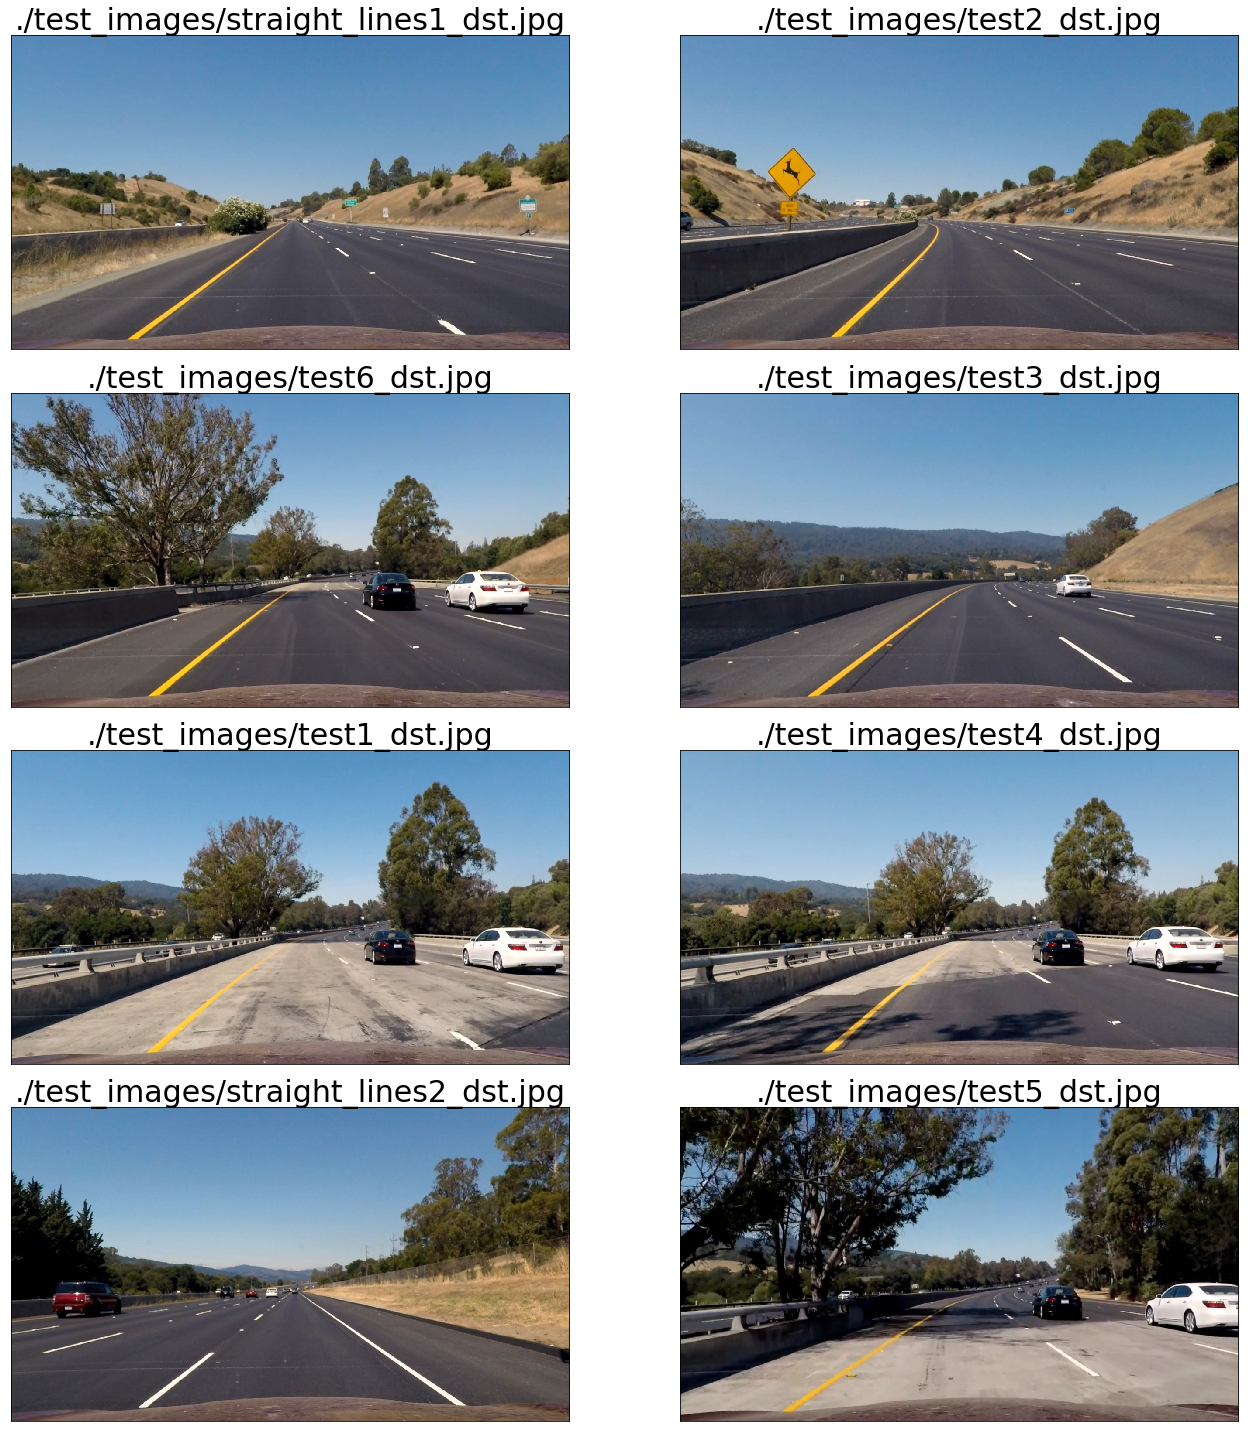

In [14]:
plot_all_images(test_images_path)

## apply some binary mask search

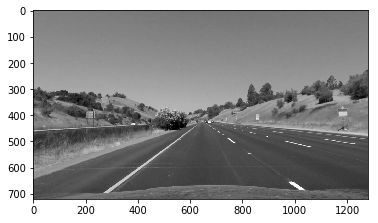

In [15]:
img = cv2.imread('./test_images/straight_lines1_dst.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

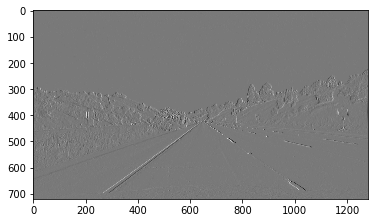

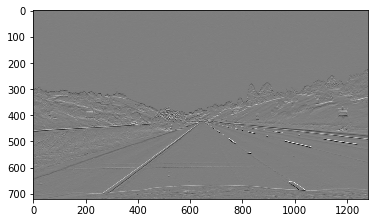

In [16]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

plt.imshow(sobelx, cmap='gray'); plt.show()
plt.imshow(sobely, cmap='gray'); plt.show()

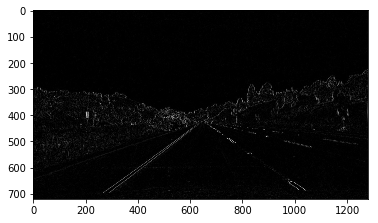

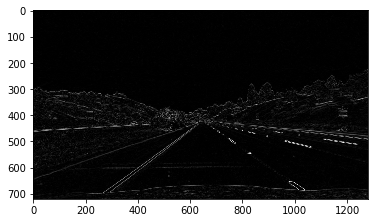

In [19]:
sobelx_norm = sobel_filter(sobelx)
sobely_norm = sobel_filter(sobely)

plt.imshow(sobelx_norm, cmap='gray'); plt.show()
plt.imshow(sobely_norm, cmap='gray'); plt.show()

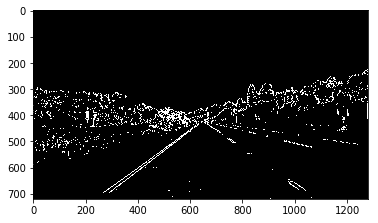

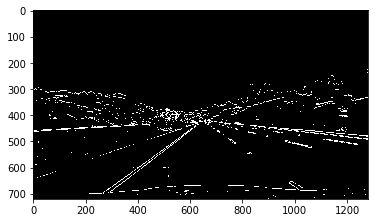

In [20]:
sx_binary = apply_threshholding(sobelx_norm, 25, 200)
sy_binary = apply_threshholding(sobely_norm, 40, 200)

plt.imshow(sx_binary, cmap='gray'); plt.show()
plt.imshow(sy_binary, cmap='gray'); plt.show()

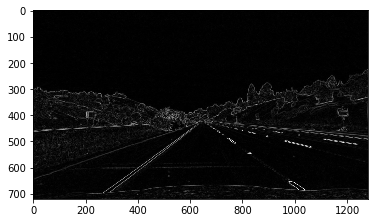

In [21]:
sobel_mag = gradient_magnitude(sobelx, sobely)

plt.imshow(sobel_mag, cmap='gray')

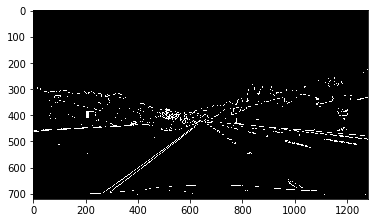

In [25]:
smag_binary = apply_threshholding(sobel_mag, 60, 200)

plt.imshow(smag_binary, cmap='gray')

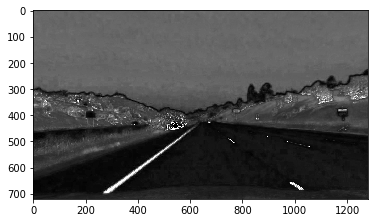

In [26]:
img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.imshow(img_hls[:, :, 2], cmap='gray')

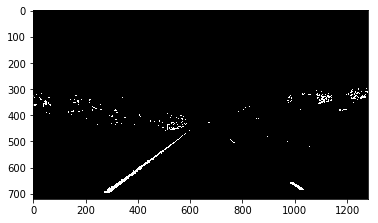

In [35]:
hls_sch_binary = apply_threshholding(img_hls[:, :, 2], 140, 255)

plt.imshow(hls_sch_binary, cmap='gray')

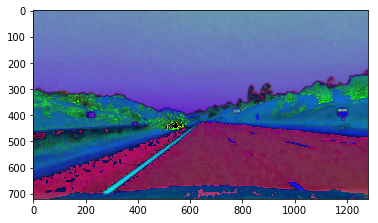

In [36]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.imshow(img_hsv)

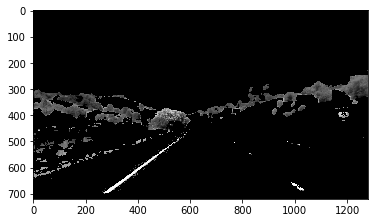

In [41]:
hsv_binary = get_hsv_color_range(img_hsv, [20,0,0], [40,255,255])
v_range_binary = hsv_binary[:, :, 2]

plt.imshow(v_range_binary, cmap='gray')

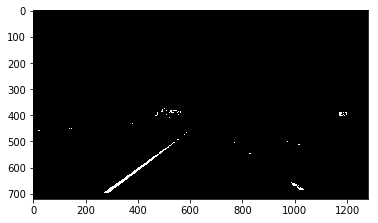

In [42]:
hsv_range_binary = apply_threshholding(v_range_binary, 180, 255)

plt.imshow(hsv_range_binary, cmap='gray')

## use all binary mask

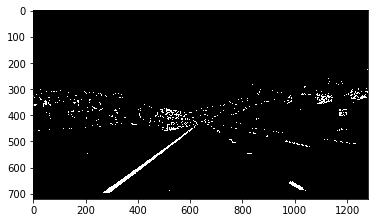

In [45]:
binary = np.zeros_like(hsv_range_binary)
binary[((sx_binary == 1) & (sy_binary == 1) & (smag_binary == 1)) | 
       (hls_sch_binary == 1) | (hsv_range_binary == 1)] = 1

plt.imshow(binary, cmap='gray')

## apply perspective transform

In [46]:
with open('./experimental/perspective_mtx.pickle', 'rb') as f:
    perspective_mtx = pickle.load(f)

In [47]:
M = perspective_mtx['M']
MInv = perspective_mtx['MInv']

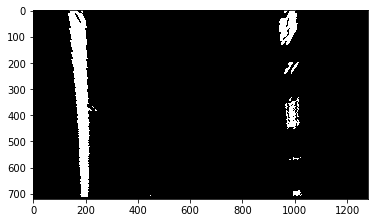

In [48]:
binary_warped = cv2.warpPerspective(binary, M, binary.shape[::-1])

plt.imshow(binary_warped, cmap='gray')

## Lane Finding

### peak

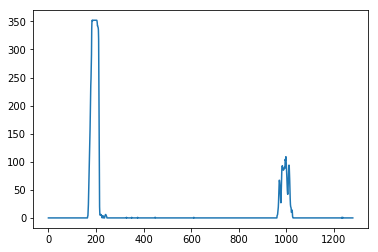

In [49]:
bottom_half = binary_warped[binary_warped.shape[0]//2:, :]
histogram = np.sum(bottom_half, axis=0)
plt.plot(histogram)

In [50]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

In [51]:
midpoint = np.int(histogram.shape[0] // 2)
midpoint

640

In [52]:
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

leftx_base, rightx_base

(184, 998)

In [53]:
nwindows = 9
margin = 100
minpix = 50

In [54]:
window_height = np.int(binary_warped.shape[0] // nwindows)
window_height

80

In [57]:
nonzero = binary_warped.nonzero()
nonzero

(array([  0,   0,   0, ..., 713, 713, 715]),
 array([ 138,  139,  140, ..., 1233, 1237,  611]))

In [58]:
# Caution!! Wrong Order Y-x
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [59]:
leftx_current = leftx_base
rightx_current = rightx_base

In [61]:
left_lane_inds = []
right_lane_inds = []

height, width = binary_warped.shape

for window in range(nwindows):
    
    win_y_low  = height - (window + 1) * window_height
    win_y_high = height - window     * window_height
    
    win_xleft_low  = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low  = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img, (win_xleft_low, win_y_low),
        (win_xleft_high, win_y_high), (0, 255, 0), 2) 
    cv2.rectangle(out_img, (win_xright_low, win_y_low),
        (win_xright_high, win_y_high), (0, 255, 0), 2) 
    
    good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    

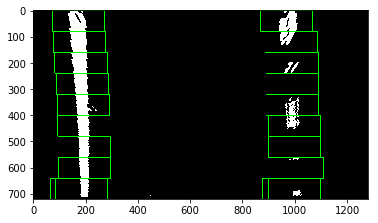

In [62]:
plt.imshow(out_img)

In [63]:
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

In [64]:
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [65]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [66]:
left_fit

array([ -6.32934051e-05,   9.21270872e-02,   1.63496851e+02])

In [67]:
right_fit

array([  5.57683045e-05,   1.44787697e-02,   9.74484841e+02])

In [68]:
ploty = np.linspace(0, height-1, height)

In [69]:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [70]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

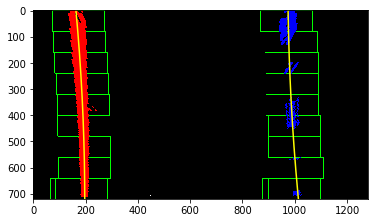

In [71]:
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [83]:
left_line_window1 = np.array(np.transpose(np.vstack([left_fitx-margin, ploty])))
left_line_window1

array([[  63.49685149,    0.        ],
       [  63.58891529,    1.        ],
       [  63.68085249,    2.        ],
       ..., 
       [  97.0135297 ,  717.        ],
       [  97.01483075,  718.        ],
       [  97.01600522,  719.        ]])

In [87]:
np.transpose(np.vstack([left_fitx+margin, ploty]))

array([[ 263.49685149,    0.        ],
       [ 263.58891529,    1.        ],
       [ 263.68085249,    2.        ],
       ..., 
       [ 297.0135297 ,  717.        ],
       [ 297.01483075,  718.        ],
       [ 297.01600522,  719.        ]])

In [88]:
np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))

array([[ 297.01600522,  719.        ],
       [ 297.01483075,  718.        ],
       [ 297.0135297 ,  717.        ],
       ..., 
       [ 263.68085249,    2.        ],
       [ 263.58891529,    1.        ],
       [ 263.49685149,    0.        ]])

In [89]:
left_line_window2 = np.array(np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty]))))

In [105]:
np.hstack((left_line_window1, left_line_window2))

array([[  63.49685149,    0.        ,  297.01600522,  719.        ],
       [  63.58891529,    1.        ,  297.01483075,  718.        ],
       [  63.68085249,    2.        ,  297.0135297 ,  717.        ],
       ..., 
       [  97.0135297 ,  717.        ,  263.68085249,    2.        ],
       [  97.01483075,  718.        ,  263.58891529,    1.        ],
       [  97.01600522,  719.        ,  263.49685149,    0.        ]])

In [106]:
left_line_pts = np.hstack((left_line_window1, left_line_window2))

In [93]:
right_line_window1 = np.array(np.transpose(np.vstack([right_fitx-margin, ploty])))
right_line_window2 = np.array(np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty]))))
right_line_pts = np.hstack((right_line_window1, right_line_window2))

In [94]:
out_img.shape

(720, 1280, 3)

In [95]:
window_img = np.zeros_like(out_img)
window_img.shape

(720, 1280, 3)

In [107]:
np.int_([left_line_pts])

array([[[ 63,   0],
        [ 63,   1],
        [ 63,   2],
        ..., 
        [263,   2],
        [263,   1],
        [263,   0]]])

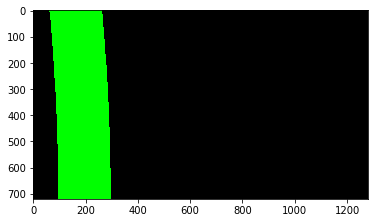

In [108]:
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))

plt.imshow(window_img)